In [1]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))



GPU Available: []


# 1️⃣  Import Essential Modules  📂


In [2]:
# Data Handling & Processing
import numpy as np
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data Preprocessing & Scaling
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

# Handling Class Imbalance
from imblearn.over_sampling import SMOTE

# Splitting Data
from sklearn.model_selection import train_test_split

# TensorFlow & Keras (for Deep Learning)
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Model Evaluation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score

# Explainability (SHAP)
import shap

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# 2️⃣ About the Dataset 📂



In [3]:
df = pd.read_csv("/content/sample_data/diabetes_prediction_dataset.csv")
reserved_df = df.copy()
df.head(10)


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
5,Female,20.0,0,0,never,27.32,6.6,85,0
6,Female,44.0,0,0,never,19.31,6.5,200,1
7,Female,79.0,0,0,No Info,23.86,5.7,85,0
8,Male,42.0,0,0,never,33.64,4.8,145,0
9,Female,32.0,0,0,never,27.32,5.0,100,0


In [4]:
df.duplicated().sum()


np.int64(3854)

In [5]:
df['age'] = df['age'].astype('int')

In [6]:
df = df.drop_duplicates(ignore_index=True)

In [7]:
df.duplicated().sum()

np.int64(0)

# 3️⃣ Data Cleaning & Preprocessing 🛠️

In [8]:
column = ['smoking_history']
one_hot_encoder = OneHotEncoder(sparse_output=True, dtype=int)
feature_columns = one_hot_encoder.fit_transform(df[column]).toarray()


In [9]:
encoded_df = pd.DataFrame(feature_columns, columns=one_hot_encoder.get_feature_names_out())


In [10]:
print(encoded_df.columns)

Index(['smoking_history_No Info', 'smoking_history_current',
       'smoking_history_ever', 'smoking_history_former',
       'smoking_history_never', 'smoking_history_not current'],
      dtype='object')


In [11]:
encoded_df.dtypes


,0
smoking_history_No Info,int64
smoking_history_current,int64
smoking_history_ever,int64
smoking_history_former,int64
smoking_history_never,int64
smoking_history_not current,int64


In [12]:
encoded_df['smoking_history_never_smoked'] = (encoded_df['smoking_history_never'] + encoded_df['smoking_history_No Info']).astype(int)

encoded_df['smoking_history_smoked_before'] = (encoded_df['smoking_history_former'] + encoded_df['smoking_history_not current']).astype(int)

encoded_df['smoking_history_smoking'] = (encoded_df['smoking_history_current'] + encoded_df['smoking_history_ever']).astype(int)

encoded_df = encoded_df.drop(columns=['smoking_history_No Info','smoking_history_current','smoking_history_ever','smoking_history_former','smoking_history_never','smoking_history_not current'], axis=1)

In [13]:
encoded_df.head()


,smoking_history_never_smoked,smoking_history_smoked_before,smoking_history_smoking
0,1,0,0
1,1,0,0
2,1,0,0
3,0,0,1
4,0,0,1


In [14]:
gender = ['gender']
gender_columns = one_hot_encoder.fit_transform(df[gender]).toarray()

In [15]:
encoded_gender_df = pd.DataFrame(gender_columns, columns=one_hot_encoder.get_feature_names_out(gender))


In [16]:
encoded_gender_df['gender_female'] = encoded_gender_df['gender_Female'].astype(int)

encoded_gender_df['gender_male'] = encoded_gender_df['gender_Male'].astype(int)

encoded_gender_df['other'] = encoded_gender_df['gender_Other'].astype(int)

encoded_gender_df = encoded_gender_df.drop(columns=['gender_Female', 'gender_Male', 'gender_Other', 'other'], axis=1)

In [17]:
encoded_gender_df.head()

,gender_female,gender_male
0,1,0
1,1,0
2,0,1
3,1,0
4,0,1


In [18]:
df = df.drop(columns=["smoking_history", "gender"])

In [19]:
df = pd.concat([df, encoded_df, encoded_gender_df], axis=1)

df = df[[col for col in df.columns if col != 'diabetes'] + ['diabetes']]

In [20]:
df.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,smoking_history_never_smoked,smoking_history_smoked_before,smoking_history_smoking,gender_female,gender_male,diabetes
0,80,0,1,25.19,6.6,140,1,0,0,1,0,0
1,54,0,0,27.32,6.6,80,1,0,0,1,0,0
2,28,0,0,27.32,5.7,158,1,0,0,0,1,0
3,36,0,0,23.45,5.0,155,0,0,1,1,0,0
4,76,1,1,20.14,4.8,155,0,0,1,0,1,0


In [21]:
df.to_csv("transformed_data.csv", index=False)

In [22]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,smoking_history_never_smoked,smoking_history_smoked_before,smoking_history_smoking,gender_female,gender_male,diabetes
count,96112.000000,96112.000000,96112.000000,96112.000000,96112.000000,96112.000000,96112.000000,96112.000000,96112.000000,96112.000000,96112.000000,96112.000000
mean,41.798287,0.077628,0.040817,27.321923,5.532618,138.221013,0.699715,0.162997,0.137288,0.584131,0.415682,0.088251
std,22.472901,0.267587,0.197867,6.768534,1.073288,40.911287,0.458384,0.369365,0.344153,0.492874,0.492842,0.283661
min,0.000000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,0.000000,0.000000,23.400000,4.800000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,43.000000,0.000000,0.000000,27.320000,5.800000,140.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,59.000000,0.000000,0.000000,29.860000,6.200000,159.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,80.000000,1.000000,1.000000,95.690000,9.000000,300.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
missing_values_count = df.isnull().sum()
for column, count in missing_values_count.items():
    print(f'The total number of empty values in {column} is {count}.')

The total number of empty values in age is 0.
The total number of empty values in hypertension is 0.
The total number of empty values in heart_disease is 0.
The total number of empty values in bmi is 0.
The total number of empty values in HbA1c_level is 0.
The total number of empty values in blood_glucose_level is 0.
The total number of empty values in smoking_history_never_smoked is 0.
The total number of empty values in smoking_history_smoked_before is 0.
The total number of empty values in smoking_history_smoking is 0.
The total number of empty values in gender_female is 0.
The total number of empty values in gender_male is 0.
The total number of empty values in diabetes is 0.


In [24]:
unique_details = {column: len(df[column].unique()) for column in df.columns}
for key, value in unique_details.items():
    print(f'The number of unique values in {key} is {value}.')

The number of unique values in age is 81.
The number of unique values in hypertension is 2.
The number of unique values in heart_disease is 2.
The number of unique values in bmi is 4247.
The number of unique values in HbA1c_level is 18.
The number of unique values in blood_glucose_level is 18.
The number of unique values in smoking_history_never_smoked is 2.
The number of unique values in smoking_history_smoked_before is 2.
The number of unique values in smoking_history_smoking is 2.
The number of unique values in gender_female is 2.
The number of unique values in gender_male is 2.
The number of unique values in diabetes is 2.


In [25]:
numerical_features = [feature for feature in df.columns if df[feature].dtypes != 'O']
print("The number of numerical features is", len(numerical_features), "and they are : \n", numerical_features)

The number of numerical features is 12 and they are : 
 ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'smoking_history_never_smoked', 'smoking_history_smoked_before', 'smoking_history_smoking', 'gender_female', 'gender_male', 'diabetes']


In [26]:
discrete_feature = [feature for feature in numerical_features if df[feature].nunique() <= 15]
print("The number of discrete features is", len(discrete_feature), "and they are : \n", discrete_feature)

The number of discrete features is 8 and they are : 
 ['hypertension', 'heart_disease', 'smoking_history_never_smoked', 'smoking_history_smoked_before', 'smoking_history_smoking', 'gender_female', 'gender_male', 'diabetes']


In [27]:
continuous_feature=[feature for feature in numerical_features if feature not in discrete_feature]
print("The number of continuous_feature features is",len(continuous_feature),"and they are : \n",continuous_feature)

The number of continuous_feature features is 4 and they are : 
 ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']


In [28]:
def countplot_distribution(col):
    sns.set_theme(style="darkgrid")
    sns.countplot(y=col, data=df).set(title='Distribution of ' + col)

def histplot_distribution(col):
    sns.set_theme(style="darkgrid")
    sns.histplot(data=df, x=col, kde=True, color="red").set(title='Distribution of ' + col)

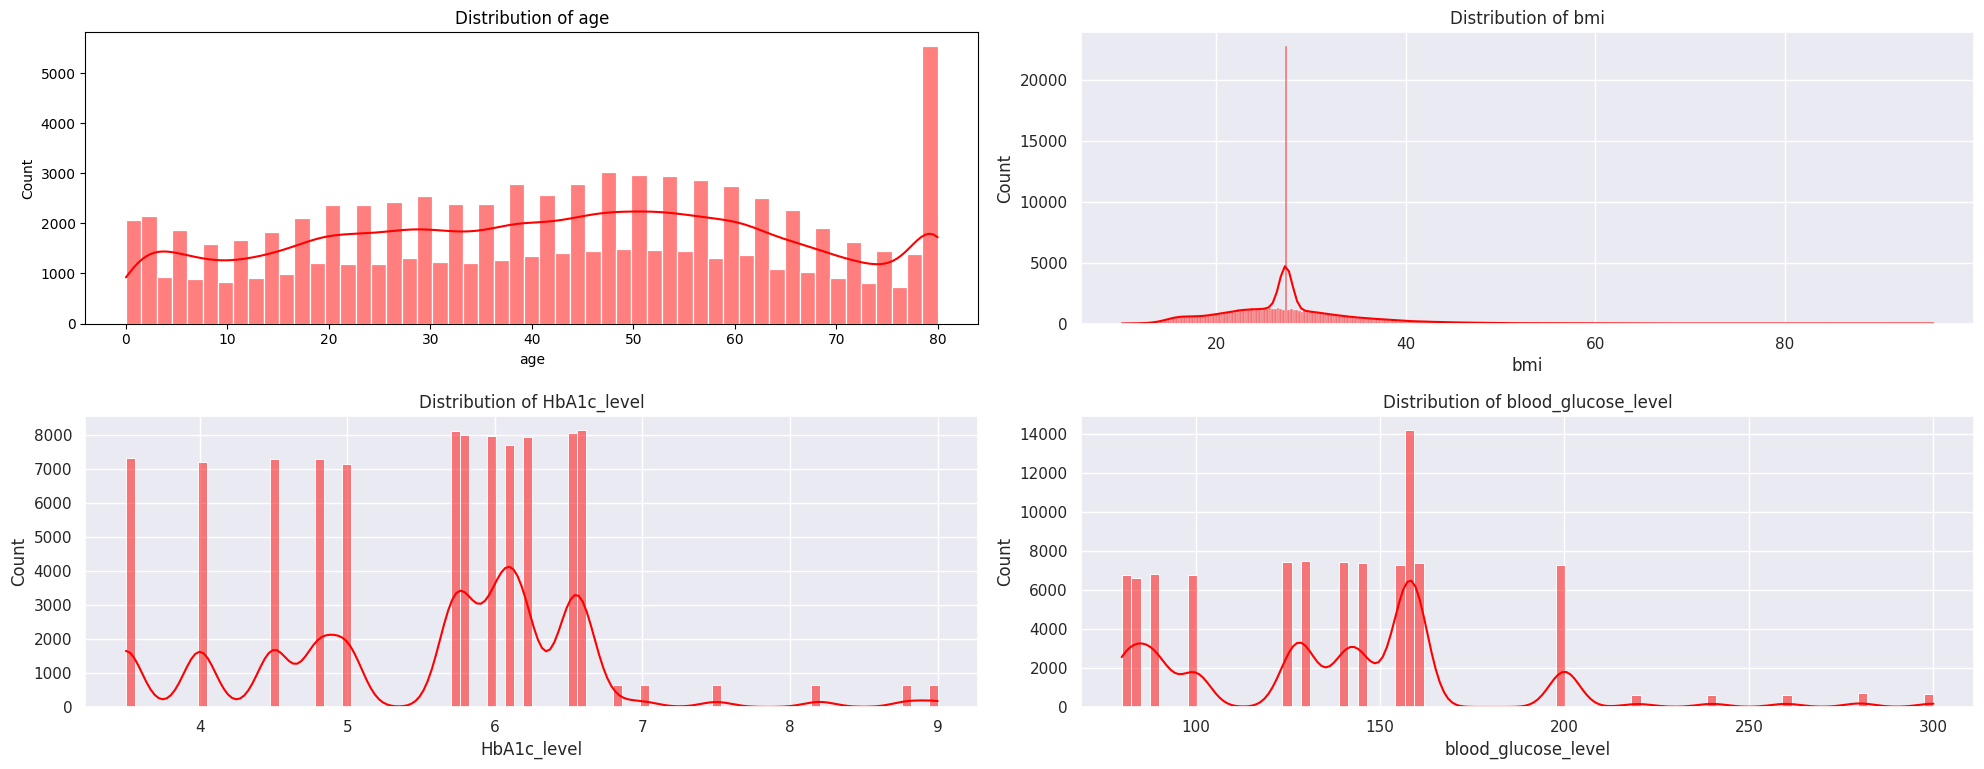

In [29]:
f = plt.figure(figsize=(20,15))
for i in range(len(continuous_feature)):
    f.add_subplot(len(continuous_feature), 2, i+1)
    histplot_distribution(continuous_feature[i])
    plt.tight_layout()
plt.show()

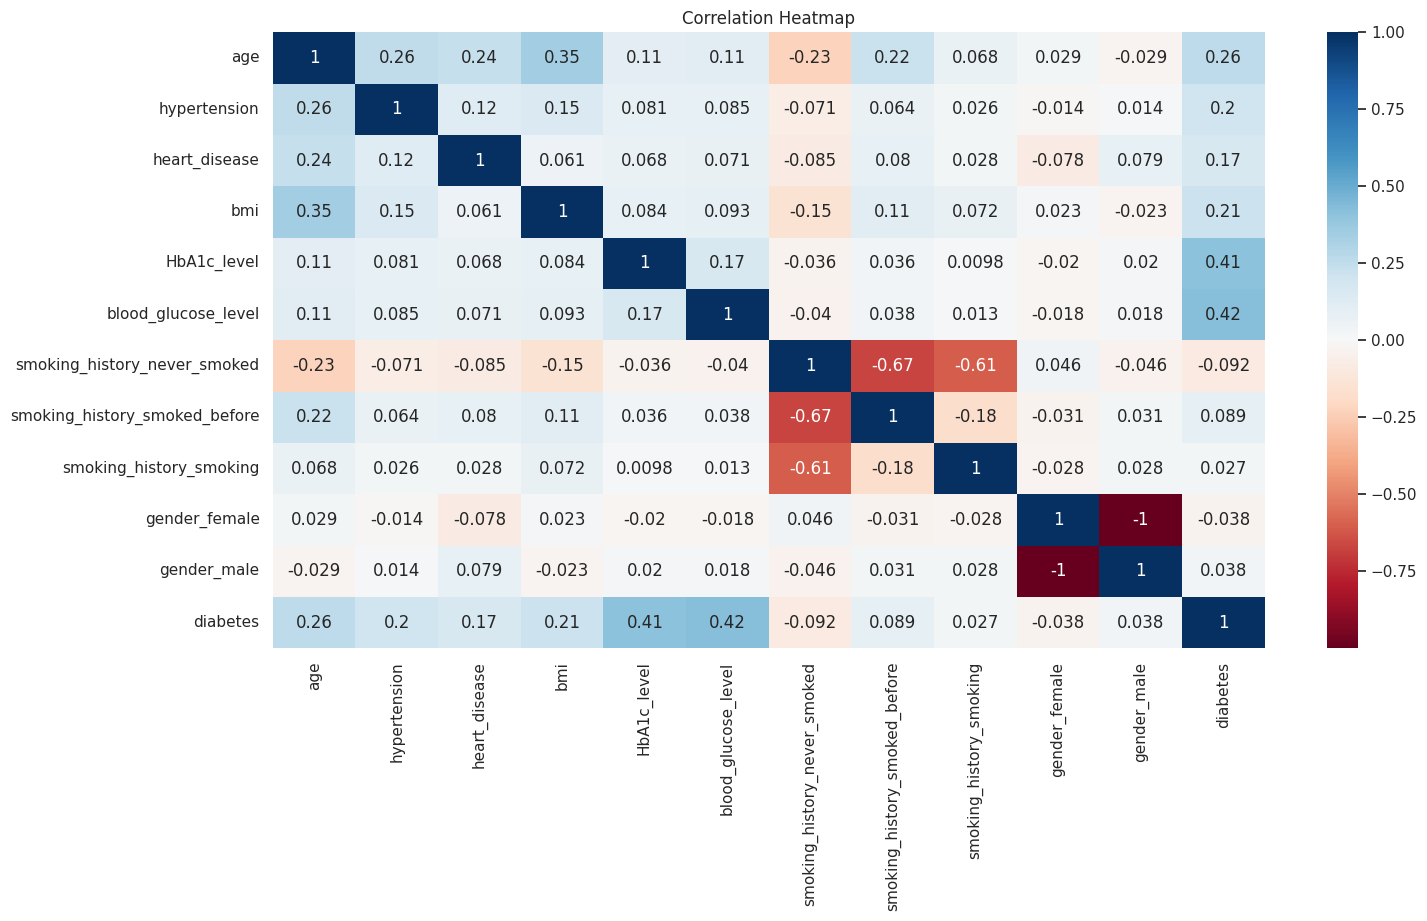

In [30]:
corr = df.corr()
plt.figure(figsize=[16, 8])
sns.heatmap(corr, cmap=plt.cm.RdBu, annot=True)
plt.title("Correlation Heatmap")
plt.show()

In [31]:
corr = df.corr()
correlation_with_target = corr['diabetes'].drop('diabetes')
top_features = correlation_with_target.abs().sort_values(ascending=False).head(3)
print("Top 3 features most correlated with diabetes are:")
print(top_features)

Top 3 features most correlated with diabetes are:
blood_glucose_level    0.424381
HbA1c_level            0.406463
age                    0.264806
Name: diabetes, dtype: float64


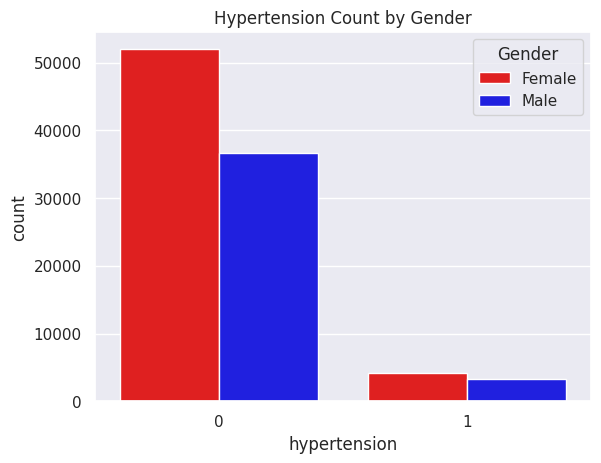

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='hypertension', hue='gender_male', data=df, palette=('red', 'blue'))
plt.legend(title="Gender", labels=['Female', 'Male'])
plt.title("Hypertension Count by Gender")
plt.show()


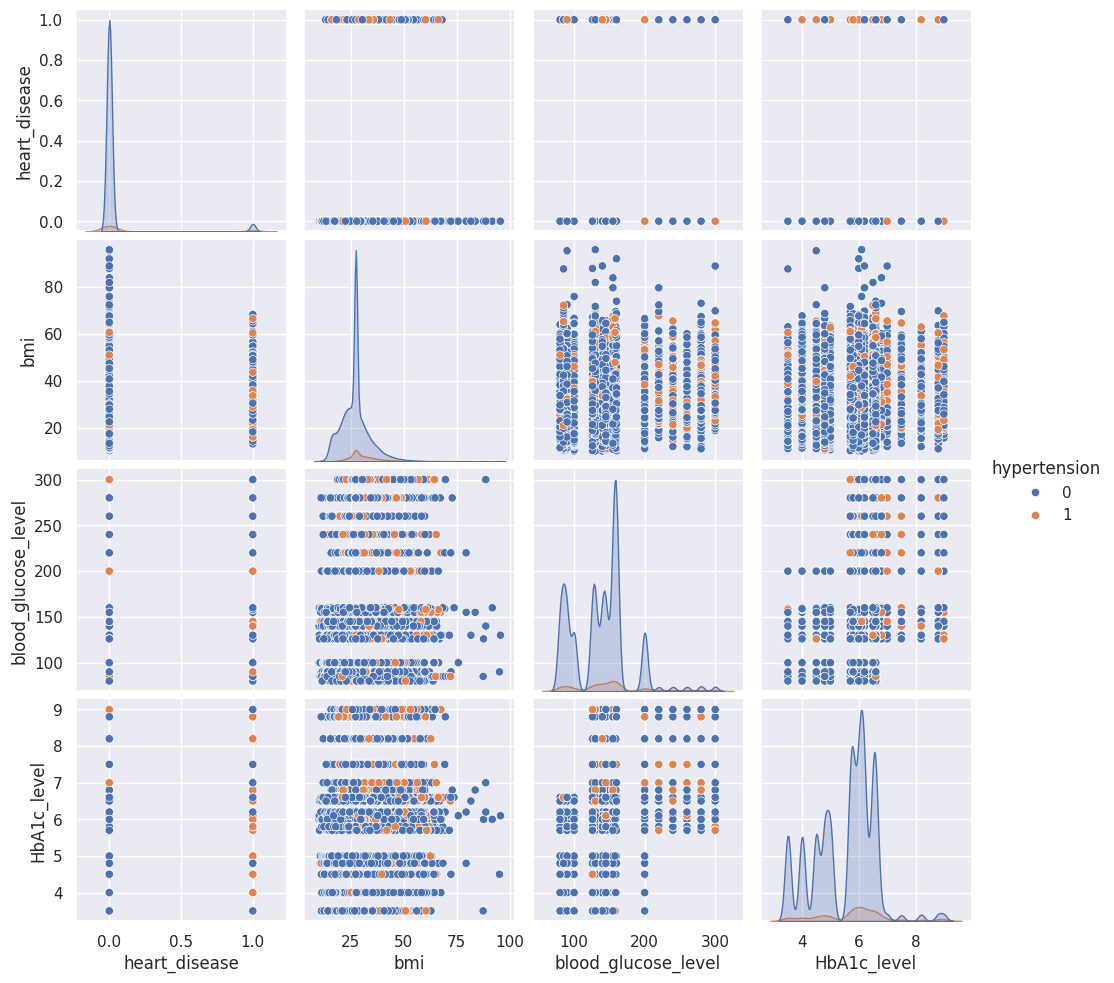

In [33]:
sns.pairplot(df, hue='hypertension', vars=['heart_disease', 'bmi', 'blood_glucose_level', 'HbA1c_level'])


In [34]:
corr = df.corr()
correlation_with_target = corr['diabetes'].drop('diabetes')
top_features = correlation_with_target.abs().sort_values(ascending=False).head(3)
print("Top 3 features most correlated with diabetes are:")
print(top_features)

Top 3 features most correlated with diabetes are:
blood_glucose_level    0.424381
HbA1c_level            0.406463
age                    0.264806
Name: diabetes, dtype: float64


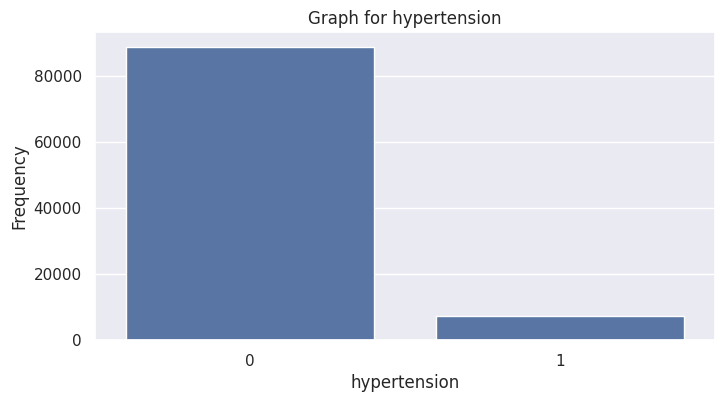

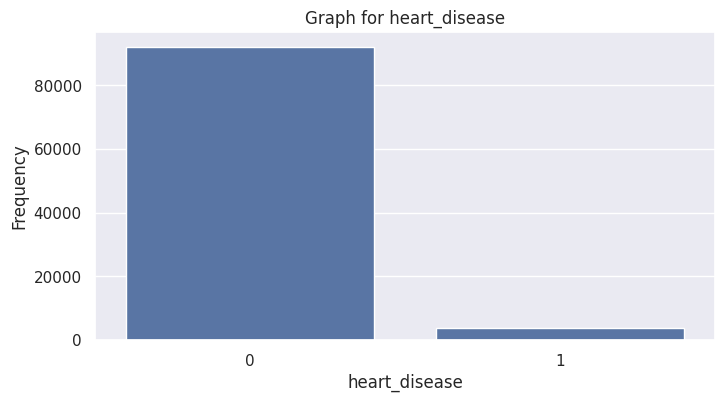

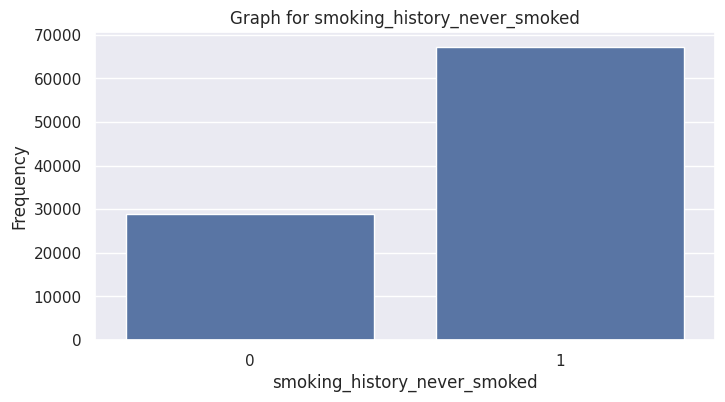

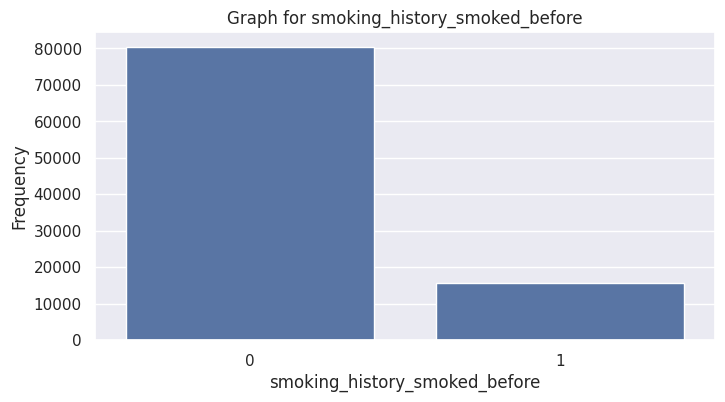

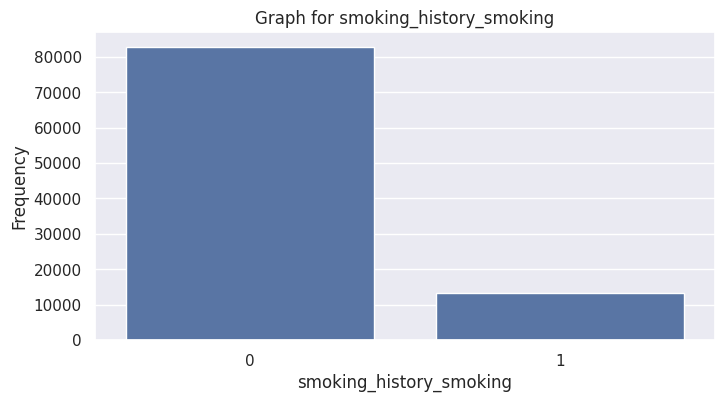

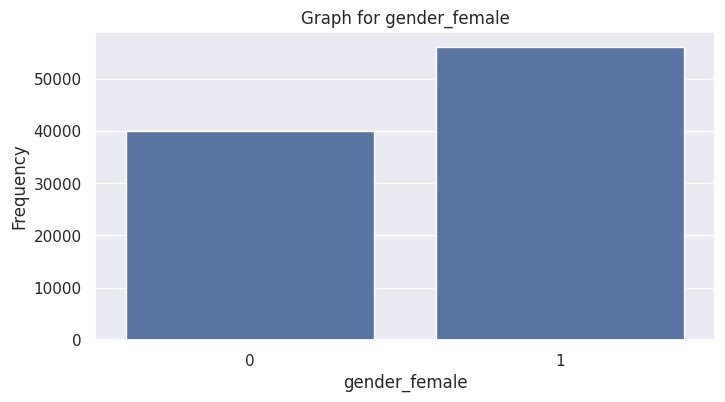

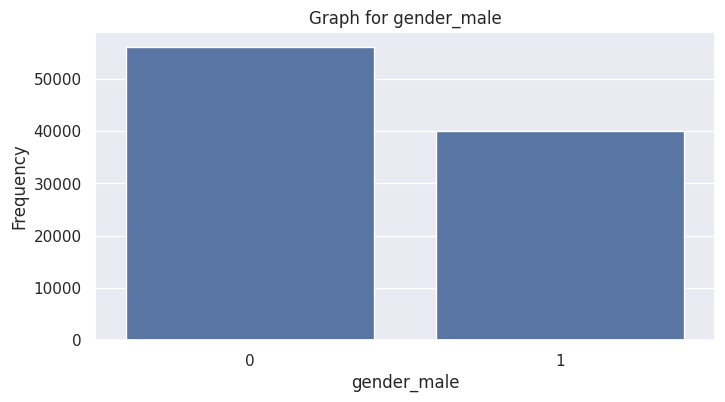

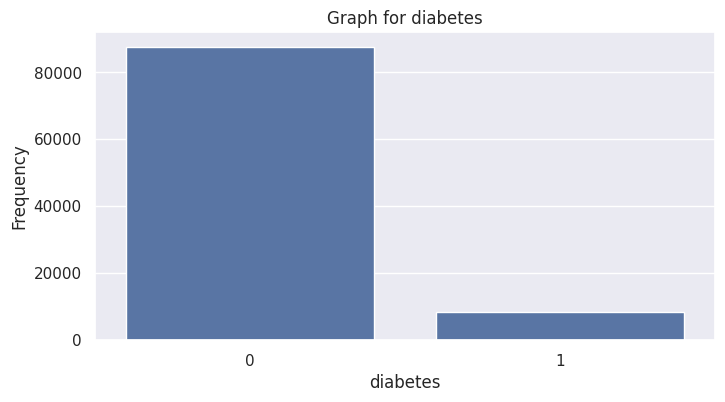

In [35]:
for feature in discrete_feature:
    plt.figure(figsize=(8,4))
    cat_num = df[feature].value_counts()
    sns.barplot(x=cat_num.index, y=cat_num).set(title="Graph for "+feature, ylabel="Frequency")
    plt.show()


In [36]:
# Step 1: Separate features and target
X = df.drop('diabetes', axis=1)
Y = df['diabetes']

# Step 2: Normalize/Standardize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Split into 70% training and 30% testing set
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.3, random_state=42)


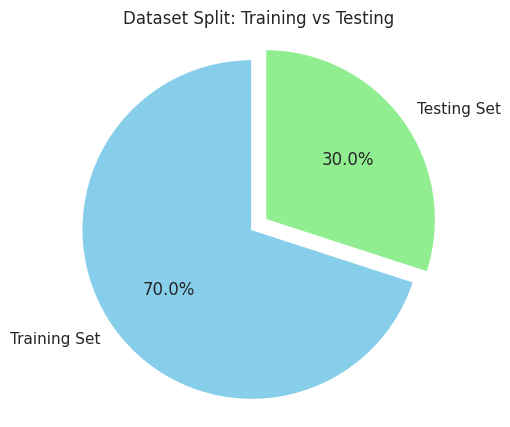

In [37]:
# Visualizing Train-Test Split (70/30)
train_size = len(X_train)
test_size = len(X_test)

sizes = [train_size, test_size]
labels = ['Training Set', 'Testing Set']
colors = ['skyblue', 'lightgreen']

plt.figure(figsize=(6, 5))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=(0.1, 0)
)
plt.title('Dataset Split: Training vs Testing')
plt.axis('equal')  # Ensures pie is a circle
plt.show()


In [38]:
print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

Training set size: 67278
Testing set size: 28834


#SMOTE to balance the minority class

In [39]:
pip install imbalanced-learn

In [40]:
#Handle class imbalance with SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, Y_resampled = smote.fit_resample(X_train, Y_train)

In [83]:
print(X_resampled.shape)  # Check the number of columns

(122746, 11)


#Building The Autoencoder Model

In [41]:
from tensorflow import keras
from tensorflow.keras import layers


In [42]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Define input dimension and encoding size
input_dim = X_train.shape[1]
encoding_dim = 8

# Functional API for Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Build Autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the Autoencoder
history = autoencoder.fit(
    X_resampled, X_resampled,
    epochs=30,
    batch_size=120,
    shuffle=True,
    validation_data=(X_test, X_test)
)

# Extract Encoder Model (for feature extraction)
encoder = Model(inputs=input_layer, outputs=encoded)

# Encode the data
X_train_encoded = encoder.predict(X_resampled)
X_test_encoded = encoder.predict(X_test)


Epoch 1/30
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1211 - val_loss: 0.0145
Epoch 2/30
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0159 - val_loss: 0.0069
Epoch 3/30
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0098 - val_loss: 0.0050
Epoch 4/30
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0058 - val_loss: 0.0038
Epoch 5/30
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0042 - val_loss: 0.0029
Epoch 6/30
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 7/30
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 8/30
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 9/30
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 10/30
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 11/30
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 12/30
1023/1023 ━━━━━━━

In [72]:
!pip install hyperopt scikeras

from hyperopt import hp, tpe, fmin, Trials, space_eval
from sklearn.model_selection import cross_val_score
from scikeras.wrappers import KerasClassifier
from tensorflow import keras
from tensorflow.keras import layers


In [51]:
# Train the model with batch size 32 (or any other you want to try)
final_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_encoded.shape[1],)),  # hidden_layer1 from best params
    layers.Dense(32, activation='relu'),    # hidden_layer2 from best params
    layers.Dense(1, activation='sigmoid')
])


final_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

# Re-train with new batch size (e.g., 32 instead of 64)
history = final_model.fit(
    X_train_encoded, Y_resampled,
    epochs=90,
    batch_size=32,  # ← Try different values here like 32, 128
    validation_data=(X_test_encoded, Y_test),
    verbose=1
)

Epoch 1/90
3836/3836 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8474 - loss: 0.3510 - val_accuracy: 0.8509 - val_loss: 0.3082
Epoch 2/90
3836/3836 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.8767 - loss: 0.2688 - val_accuracy: 0.9125 - val_loss: 0.1907
Epoch 3/90
3836/3836 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8810 - loss: 0.2601 - val_accuracy: 0.8524 - val_loss: 0.3098
Epoch 4/90
3836/3836 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8826 - loss: 0.2569 - val_accuracy: 0.9017 - val_loss: 0.2106
Epoch 5/90
3836/3836 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8811 - loss: 0.2578 - val_accuracy: 0.8614 - val_loss: 0.2925
Epoch 6/90
3836/3836 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8848 - loss: 0.2519 - val_accuracy: 0.8714 - val_loss: 0.2748
Epoch 7/90
3836/3836 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8836 - loss: 0.2507 - val_accuracy: 0.8628 - val_loss: 0.2844
Epoch 8/90
3836/3836 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8843 - loss: 0

In [52]:
final_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,691 (10.52 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

#Evaluation of the developed Autoencoder Model

In [53]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Predict on test data
predictions = (final_model.predict(X_test_encoded) > 0.5).astype("int")

# Evaluate
model_accuracy = accuracy_score(Y_test, predictions)
model_conf_matrix = confusion_matrix(Y_test, predictions)

# Print results
print("Model Accuracy: {:.2f}%".format(model_accuracy * 100))
print("Confusion Matrix:\n", model_conf_matrix)

902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Model Accuracy: 90.92%
Confusion Matrix:
 [[23930  2327]
 [  291  2286]]


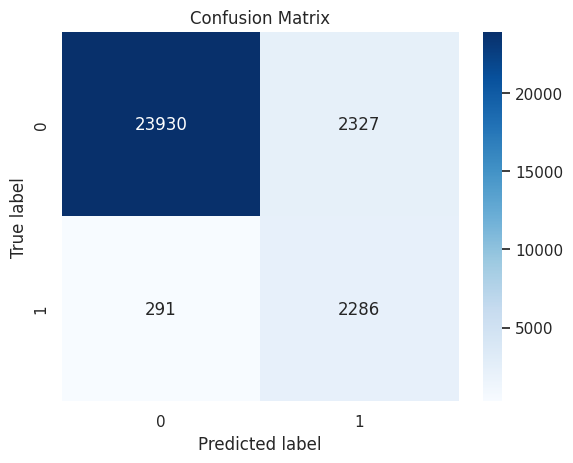

In [54]:
# Plot the confusion matrix
sns.heatmap(model_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [55]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Get predicted labels for classification report (this is Y_pred)
Y_pred = (final_model.predict(X_test_encoded) > 0.5).astype("int")

# Assume 'labels' is defined elsewhere, otherwise replace with actual target names
print(classification_report(Y_test, Y_pred, target_names=labels))

902/902 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

Training Set       0.99      0.91      0.95     26257
 Testing Set       0.50      0.89      0.64      2577

    accuracy                           0.91     28834
   macro avg       0.74      0.90      0.79     28834
weighted avg       0.94      0.91      0.92     28834



In [56]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# Predict on test data
predictions = (final_model.predict(X_test_encoded) > 0.5).astype("int")

# Evaluate
model_accuracy = accuracy_score(Y_test, predictions)
model_conf_matrix = confusion_matrix(Y_test, predictions)
model_precision = precision_score(Y_test, predictions)
model_recall = recall_score(Y_test, predictions)
model_f1 = f1_score(Y_test, predictions)


# Print results
print("Model Accuracy: {:.2f}%".format(model_accuracy * 100))
print("Model Precision: {:.2f}%".format(model_precision * 100))
print("Model Recall: {:.2f}%".format(model_recall * 100))
print("Model F1-score: {:.2f}%".format(model_f1 * 100))
print("Confusion Matrix:\n", model_conf_matrix)


902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model Accuracy: 90.92%
Model Precision: 49.56%
Model Recall: 88.71%
Model F1-score: 63.59%
Confusion Matrix:
 [[23930  2327]
 [  291  2286]]


902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


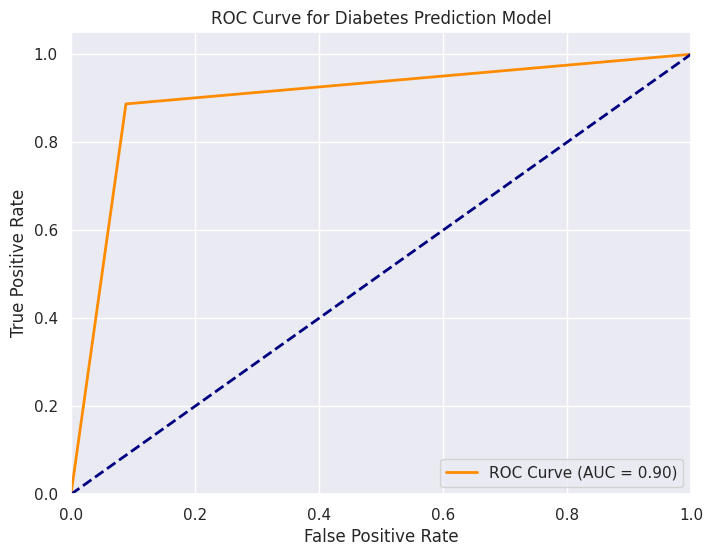

In [57]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities from the model
Y_pred_proba = final_model.predict(X_test_encoded)

# Convert probabilities to binary predictions (0 or 1)
Y_pred = (Y_pred_proba > 0.5).astype("int")

# Compute ROC values
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = roc_auc_score(Y_test, Y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random model)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Diabetes Prediction Model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


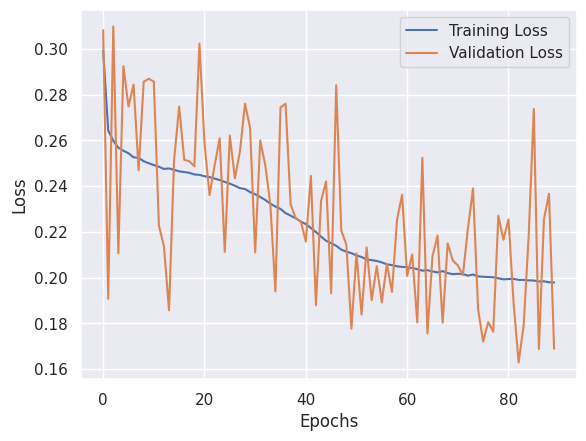

In [58]:
# Plot the training and validation loss for the classifier
plt.plot(history.history['loss'], label='Training Loss') # Use 'history' instead of 'classifier_training'
plt.plot(history.history['val_loss'], label='Validation Loss') # Use 'history' instead of 'classifier_training'
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [73]:
# Use SHAP to explain the model's predictions
explainer = shap.Explainer(final_model, X_train_encoded)
shap_values = explainer(X_test_encoded)

ExactExplainer explainer: 28835it [10:57, 43.84it/s]                           


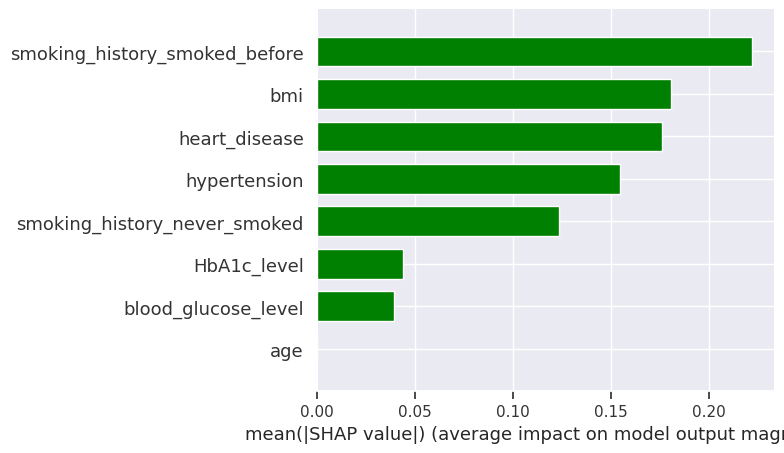

In [86]:
shap.summary_plot(shap_values, X_test_encoded, plot_type = 'bar',
                       feature_names=df.columns[:-1], color = 'green',
                       max_display=len(df.columns[:-1])) # Show all features

In [96]:
feature_names = ['encoded_feature_' + str(i) for i in range(shap_values_array.shape[1])]
# Access the values array within the shap_values object
shap_values_array = shap_values.values

# Convert SHAP values to DataFrame
shap_values_df = pd.DataFrame(shap_values_array, columns=feature_names)

# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = shap_values_df.abs().mean()

# Sort by mean absolute SHAP value
mean_abs_shap_values_sorted = mean_abs_shap_values.sort_values(ascending=False)

# Display feature names and their mean absolute SHAP values
print(mean_abs_shap_values_sorted)

encoded_feature_7    0.222184
encoded_feature_3    0.180602
encoded_feature_2    0.176217
encoded_feature_1    0.154573
encoded_feature_6    0.123451
encoded_feature_4    0.044132
encoded_feature_5    0.039488
encoded_feature_0    0.000000
dtype: float64


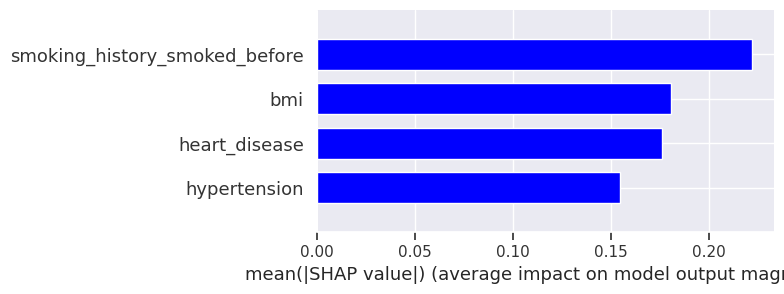

In [101]:
# Access the raw SHAP values (numpy array) from the shap_values object
new_shap_values = shap_values.values  # Get the raw SHAP values from the Explanation object

# Calculate mean absolute SHAP values
mean_abs_shap_values = np.mean(np.abs(new_shap_values), axis=0)

# Identify least important features
least_important_indices = np.argsort(mean_abs_shap_values)[:4]

# Drop least important features from data and SHAP values
X_test_encoded_dropped = np.delete(X_test_encoded, least_important_indices, axis=1)
# Since explainer.shap_values returns a list for multi-output models, we access the first element (assuming a single output)
shap_values_dropped = np.delete(new_shap_values, least_important_indices, axis=1)  # Access 'values' to get raw SHAP values
feature_names_dropped = np.delete(df.columns[:-1], least_important_indices) # Assuming 'df' is your DataFrame

# Plot SHAP summary plot without least important features
shap.summary_plot(shap_values_dropped, X_test_encoded_dropped,
                  feature_names=feature_names_dropped, plot_type='bar', color='blue')

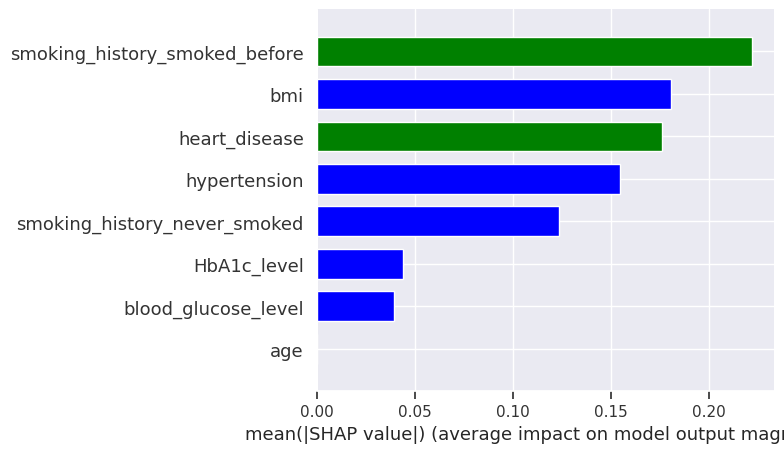

In [105]:
mean_shap_values = (shap_values.values).mean(0)
feature_colours = np.where(mean_shap_values > 0.0, 'green', 'blue')

shap.summary_plot(shap_values, X_test_encoded, plot_type = 'bar' ,
                  feature_names=df.columns[:-1], color = feature_colours)

In [107]:
feature_names = ['encoded_feature_' + str(i) for i in range(shap_values.values.shape[1])]  # Adjust to encoded features

# Calculate mean SHAP values (using shap_values.values for raw SHAP values)
mean_shap_values = np.mean(shap_values.values, axis=0)

# Create a DataFrame for easier handling
mean_shap_df = pd.DataFrame({
    'Feature': feature_names,  # Now using encoded feature names
    'Mean_SHAP_Value': mean_shap_values
})

# Display the DataFrame
mean_shap_df

,Feature,Mean_SHAP_Value
0,encoded_feature_0,0.000000
1,encoded_feature_1,-0.059031
2,encoded_feature_2,-0.075634
3,encoded_feature_3,-0.079633
4,encoded_feature_4,-0.015794
5,encoded_feature_5,0.003218
6,encoded_feature_6,-0.073253
7,encoded_feature_7,0.000625


In [113]:
# New data for prediction
new_data = {
    'age': [80],
    'hypertension': [1],
    'heart_disease': [1],
    'bmi': [28.7],
    'HbA1c_level': [6.5],
    'blood_glucose_level': [150],
    'smoking_history_never_smoked': [1], # Corrected column name
    'smoking_history_smoked_before': [0], # Corrected column name
    'smoking_history_smoking': [0],
    'gender_female': [0],
    'gender_male': [1],
}

new_data = pd.DataFrame(new_data)

# Apply the same scaling used during training
new_data_scaled = scaler.transform(new_data) # Use the 'scaler' object defined earlier

# Encode the new data using the encoder from the autoencoder
new_data_encoded = encoder.predict(new_data_scaled) # Use the encoder

# Make predictions using the encoded data
predictions = final_model.predict(new_data_encoded)

binary_predictions = (predictions > 0.5).astype(int)

# Print the predictions
if binary_predictions[0][0] == 1:
    print("Predicted class: Diabetic.")
else:
    print("Predicted class: Not diabetic")
print("Predicted probability:", predictions[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predicted class: Diabetic.
Predicted probability: 0.91183835


In [115]:
final_model.save("diabetes_model.keras")

In [116]:
import os

model_path = "diabetes_model.h5"
model_size = os.path.getsize(model_path)  # Size in bytes
model_size_MB = model_size / (1024 * 1024)  # Size in megabytes

print(f"The size of the model is {model_size_MB:.2f} MB")


The size of the model is 0.03 MB
